# Ben's Phase 1 Project Notebook

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
imdb_titles = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
imdb_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
imdb_principals = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
imdb_crews = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
imdb_akas = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
rt_movies = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding = 'unicode_escape')
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

# Rotten Tomatoes Databases
## rt_movies.csv
### rt_movies_cleaned

In [3]:
#Create rt_movies_cleaned. Drop 359 movies with no theater date.  Only reduces records with B.O. from 340 to 334.
rt_movies_cleaned = rt_movies.dropna(axis=0, subset=['theater_date'])

#Create new column 'year' for int year, and 'month' for the month str.
rt_movies_cleaned['year'] = rt_movies_cleaned.theater_date.apply(lambda x: x.split()[-1])
rt_movies_cleaned['month'] = rt_movies_cleaned.theater_date.apply(lambda x: x.split()[0])

#Remove all movies with no box office records.  Now have 334 records.
rt_movies_cleaned.dropna(axis=0, subset=['box_office'], inplace=True)
rt_movies_cleaned.reset_index(inplace=True)
rt_movies_cleaned.drop('index', axis=1, inplace=True)

In [4]:
#Remove commas from B.O. column
rt_movies_cleaned.box_office = rt_movies_cleaned.box_office.apply(lambda x: x.replace(',',''))

#Convert B.O. to ints
rt_movies_cleaned.box_office = rt_movies_cleaned.box_office.apply(lambda x: int(x))

#Convert years to ints
rt_movies_cleaned.year = rt_movies_cleaned.year.apply(lambda x: int(x))

In [5]:
#Remove all movies before 2000.  Reduces records to 326.
rt_movies_cleaned = rt_movies_cleaned[rt_movies_cleaned.year >= 2000]

In [6]:
#Find movie with rating NC17, then drop the record.  There are 325 records remaining.  
rt_movies_cleaned[rt_movies_cleaned.rating == 'NC17'].index

Int64Index([259], dtype='int64')

In [7]:
rt_movies_cleaned.drop(259, axis=0, inplace=True)

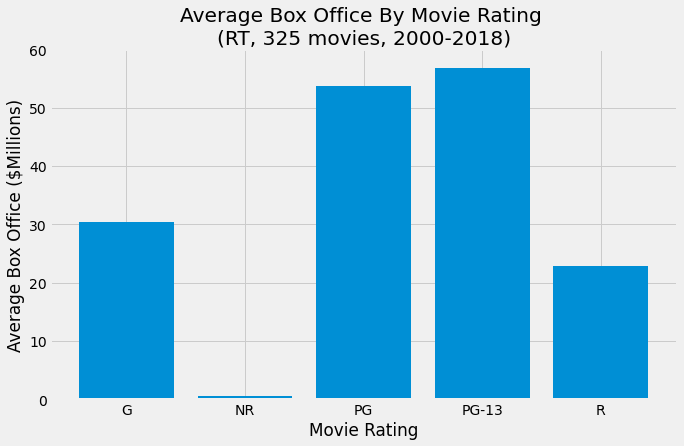

In [8]:
#Rotten Tomatoes db of 325 movies from 2000 to 2018
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_cleaned.groupby('rating').box_office.mean().index
y = rt_movies_cleaned.groupby('rating').box_office.mean().values
ax.bar(x,y)
ax.set_xlabel('Movie Rating')
ax.set_ylabel('Average Box Office ($Millions)')
ax.set_title('Average Box Office By Movie Rating \n(RT, 325 movies, 2000-2018)')
ax.set_yticks(range(0,70000000,10000000))
ax.set_yticklabels(range(0,70,10));

In [9]:
rt_movies_cleaned.groupby('month').box_office.mean().sort_values()

month
Sep    2.132493e+07
Aug    2.309728e+07
Mar    2.867936e+07
Apr    3.041570e+07
Oct    3.622466e+07
Jan    3.762174e+07
May    3.970367e+07
Jul    3.977743e+07
Feb    4.567612e+07
Dec    5.315350e+07
Jun    5.322493e+07
Nov    5.565870e+07
Name: box_office, dtype: float64

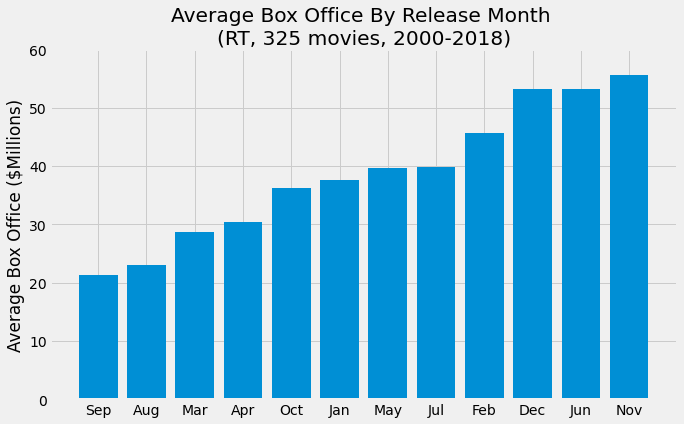

In [10]:
#Create a plot of Average BO by release month from rt_movies_cleaned
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_cleaned.groupby('month').box_office.mean().sort_values().index
y = rt_movies_cleaned.groupby('month').box_office.mean().sort_values().values
ax.bar(x,y)
ax.set_ylabel('Average Box Office ($Millions)')
ax.set_title('Average Box Office By Release Month \n(RT, 325 movies, 2000-2018)')
ax.set_yticks(range(0,70000000,10000000))
ax.set_yticklabels(range(0,70,10));

### rt_movies_runtime

In [11]:
#create a subset of rt_movies_cleaned to remove NaNs from runtime, leaving 323 records
rt_movies_runtime = rt_movies_cleaned.dropna(axis=0, subset=['runtime'])

In [12]:
#create a new column 'minutes' that contains minutes in ints
rt_movies_runtime['minutes'] = rt_movies_runtime.runtime.apply(lambda x: int(x.split()[0]))

In [13]:
#Find the correlation between box office and runtime.
rt_movies_runtime.corr()

,id,box_office,year,minutes
id,1.000000,0.079440,0.015652,0.031163
box_office,0.079440,1.000000,-0.165534,0.232658
year,0.015652,-0.165534,1.000000,0.099582
minutes,0.031163,0.232658,0.099582,1.000000


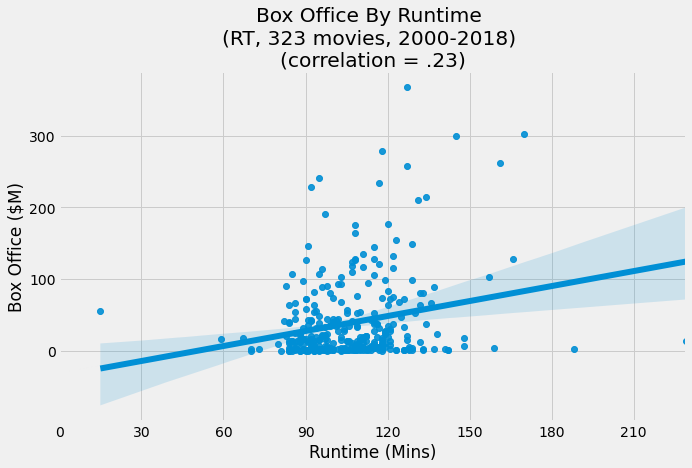

In [14]:
#Scatter plot of B.O. by runtime from RT db with 323 movies from 2000-2018
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_runtime.minutes
y = rt_movies_runtime.box_office
ax.scatter(x=x, y=y, alpha=.5)
sns.regplot(x=x,y=y)
ax.set_xlabel('Runtime (Mins)')
ax.set_ylabel('Box Office ($M)')
ax.set_title('Box Office By Runtime \n(RT, 323 movies, 2000-2018) \n(correlation = .23)')
ax.set_xticks(range(0,240, 30))
ax.set_yticks(range(0,400000000,100000000))
ax.set_yticklabels(range(0,400,100));

### rt_movies_directors

In [15]:
#create rt_movies_directors with 286 records by dropping NaNs from rt_movies_cleaned
rt_movies_directors = rt_movies_cleaned.dropna(axis=0, subset=['director'])

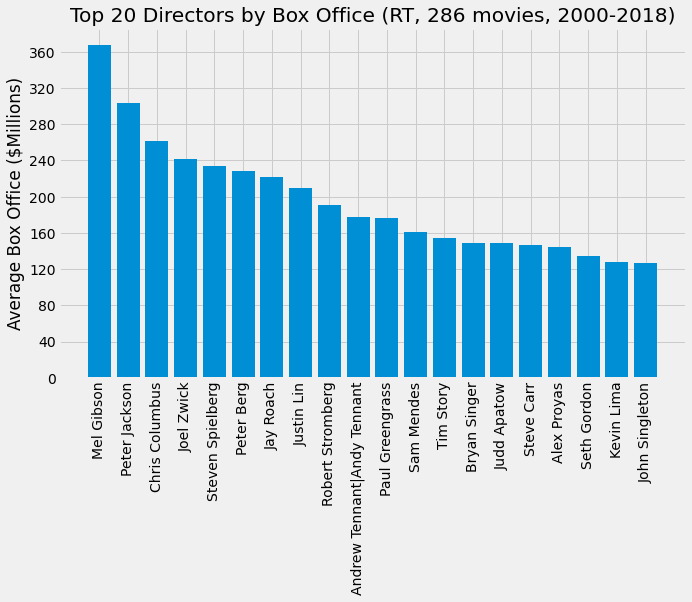

In [16]:
#Plot top 20 directors by mean B.O. Not very informative because most directors have only one movie listed.
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_directors.groupby('director').box_office.mean().sort_values(ascending=False)[:20].index
y = rt_movies_directors.groupby('director').box_office.mean().sort_values(ascending=False)[:20].values
ax.bar(x,y)
ax.set_ylabel('Average Box Office ($Millions)')
ax.set_title('Top 20 Directors by Box Office (RT, 286 movies, 2000-2018)')
ax.set_xticks(range(20))
ax.set_xticklabels(x, rotation=90)
ax.set_yticks(range(0,400000000,40000000))
ax.set_yticklabels(range(0,400,40));

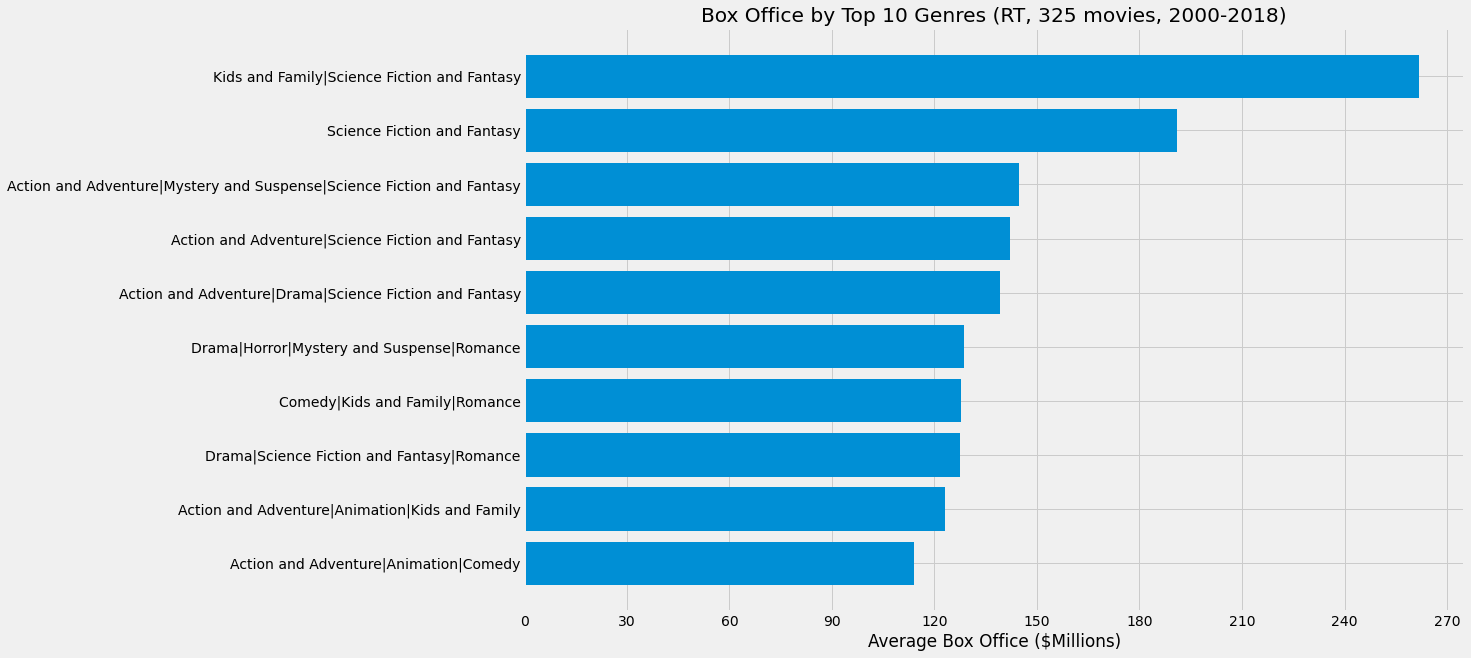

In [17]:
#Create a plot showing top 10 genres by B.O. using rt_movies_cleaned (325 records)
fig, ax = plt.subplots(figsize=(15,10))
x = rt_movies_cleaned.groupby('genre').box_office.mean().sort_values(ascending=False)[:10].sort_values().index
y = rt_movies_cleaned.groupby('genre').box_office.mean().sort_values(ascending=False)[:10].sort_values().values
ax.barh(x,y)
ax.set_xlabel('Average Box Office ($Millions)')
ax.set_title('Box Office by Top 10 Genres (RT, 325 movies, 2000-2018)')
ax.set_xticks(range(0,300000000,30000000))
ax.set_xticklabels(range(0,300,30));

## rt_reviews.csv

In [18]:
#Remove all records where top_critic = 0. Reduces rt_reviews from 54,432 to 13,096 records
rt_reviews = rt_reviews[rt_reviews.top_critic == 1]

In [19]:
#Create new column 'fresh_value' that is 1 for 'fresh' movies or 0 for 'rotten' movies.
rt_reviews['fresh_value'] = rt_reviews.fresh.apply(lambda x: 1 if x == 'fresh' else 0)

In [20]:
#Create a series of the percentage of fresh reviews for each movie id (889 records)
total_reviews = rt_reviews.groupby('id').fresh_value.count()
fresh_reviews = rt_reviews.groupby('id').fresh_value.sum()
fresh_percent = fresh_reviews / total_reviews 

In [21]:
#Create a series of the number of reviews for each movie id (889 records)
num_reviews = rt_reviews.groupby('id').id.count()

In [22]:
#Merege the two series and rename the columns
merge_fresh_and_num_reviews = pd.concat([fresh_percent, num_reviews], axis=1)
merge_fresh_and_num_reviews.rename(columns={'id':'num_reviews'}, inplace=True)

In [23]:
#Remove all records with less than 10 reviews, leaving 447 records.
merge_fresh_and_num_reviews = merge_fresh_and_num_reviews[merge_fresh_and_num_reviews.num_reviews >= 10]

In [24]:
#inner merge rt_movies_cleaned with the series fresh percent into rt_movies_cleaned_reviews (268 records)
rt_movies_cleaned_reviews = rt_movies_cleaned.merge(merge_fresh_and_num_reviews, how='inner', on='id')

In [25]:
#Find the correlation between box office and fresh_value
rt_movies_cleaned_reviews.corr()

,id,box_office,year,fresh_value,num_reviews
id,1.000000,0.056055,0.011224,0.031217,0.099839
box_office,0.056055,1.000000,-0.143413,0.036135,0.343746
year,0.011224,-0.143413,1.000000,0.067402,-0.004705
fresh_value,0.031217,0.036135,0.067402,1.000000,0.352807
num_reviews,0.099839,0.343746,-0.004705,0.352807,1.000000


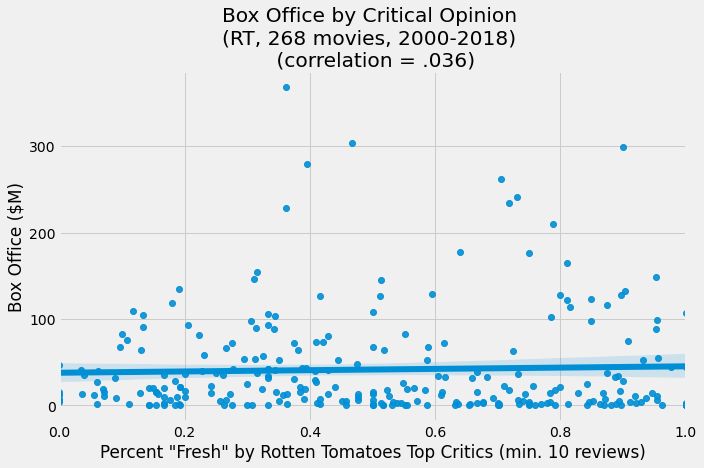

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
x = rt_movies_cleaned_reviews.fresh_value
y = rt_movies_cleaned_reviews.box_office
ax.scatter(x, y , alpha=.5)
sns.regplot(x=x,y=y)
ax.set_xlabel('Percent \"Fresh\" by Rotten Tomatoes Top Critics (min. 10 reviews)')
ax.set_ylabel('Box Office ($M)')
ax.set_title('Box Office by Critical Opinion \n(RT, 268 movies, 2000-2018) \n (correlation = .036)')
ax.set_yticks(range(0,400000000,100000000))
ax.set_yticklabels(range(0,400,100));

### import imdb_cleaned

In [27]:
imdb_cleaned = pd.read_csv('https://raw.githubusercontent.com/nate-walter/phase-1-project-mvp-repo/imdb_branch/Data/imdb_cleaned_final.csv')

In [28]:
imdb_cleaned_copy = imdb_cleaned.copy()

In [29]:
#create a new column 'release_month' to convert months to strings
month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug',
             9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
imdb_cleaned_copy['month_str'] = imdb_cleaned_copy.release_month.apply(lambda x: month_dict[x])

In [30]:
#drop all movie duplicates since I'm only interested in the release month
imdb_cleaned_copy.drop_duplicates(subset='tconst', inplace=True)

In [31]:
#find correlation between WW BO and realese month
imdb_cleaned_copy.corr()['release_month']['Worldwide Net Profit'].mean()

0.022858224533317477

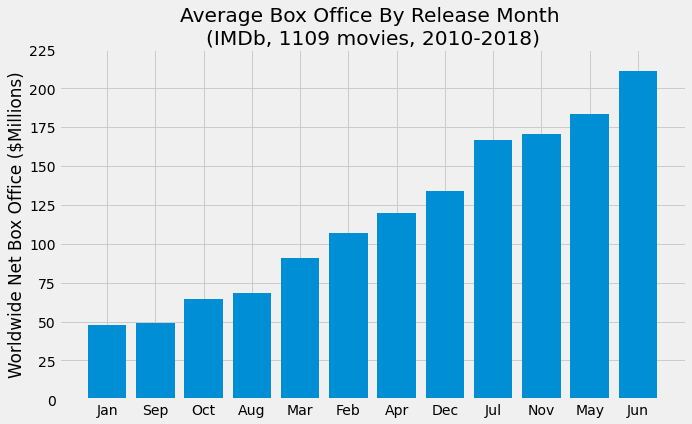

In [32]:
#create a plot WW net BO by release month using imdb_cleaned_copy
fig, ax = plt.subplots(figsize=(10,6))
x = imdb_cleaned_copy.groupby('month_str')['Worldwide Net Profit'].mean().sort_values().index
y = imdb_cleaned_copy.groupby('month_str')['Worldwide Net Profit'].mean().sort_values().values
ax.bar(x,y)
ax.set_ylabel('Worldwide Net Box Office ($Millions)')
ax.set_title('Average Box Office By Release Month \n(IMDb, 1109 movies, 2010-2018)')
ax.set_yticks(range(0,250000000,25000000))
ax.set_yticklabels(range(0,250,25));

In [33]:
#find correlation betweeen average IMDb rating and release month
imdb_cleaned_copy.corr()['averagerating']['release_month']

0.19224405323134594

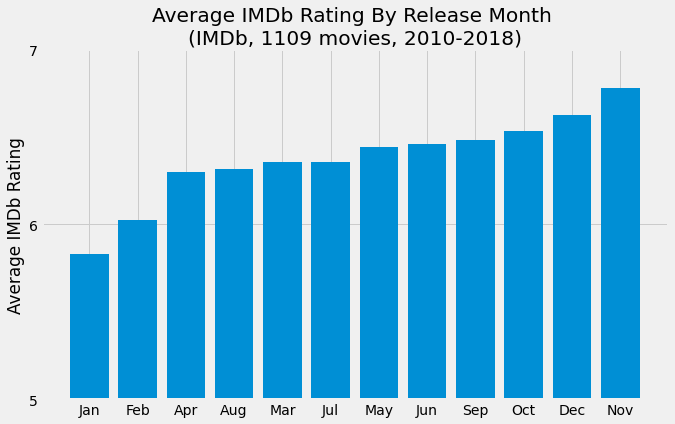

In [34]:
#create a plot average IMDb rating by relase month using imdb_cleaned_copy
fig, ax = plt.subplots(figsize=(10,6))
x = imdb_cleaned_copy.groupby('month_str').averagerating.mean().sort_values().index
y = imdb_cleaned_copy.groupby('month_str').averagerating.mean().sort_values().values
ax.bar(x,y)
ax.set_ylabel('Average IMDb Rating')
ax.set_title('Average IMDb Rating By Release Month \n(IMDb, 1109 movies, 2010-2018)')
ax.set_yticks(range(5,8,1))
ax.set_yticklabels(range(5,8,1))
ax.set_ylim(bottom=5, top=7);

## Rotten Tomatoes Data From Kaggle

In [35]:
rt_kaggle = pd.read_csv('zippedData/rotten_tomatoes_movies.csv')

In [36]:
#Set the movie titles to lowercase.  Drop records with no original release date.  
#Add a year col for int years, then drop all movies before the year 2000.
rt_kaggle['movie_title'] = rt_kaggle.movie_title.apply(lambda x: x.lower())
rt_kaggle.dropna(axis=0, subset=['original_release_date'], inplace=True)
rt_kaggle['year'] = rt_kaggle.original_release_date.apply(lambda x: int(x[:4]))
rt_kaggle = rt_kaggle[rt_kaggle.year >= 2000]

In [37]:
#Create a new df from imdb_cleaned_copy with just two columns: primary_title and Worldwide Net Profit.  Then merge 
#on the movie names with rt_kaggle creating a df with 1098 movies.  
imdb_cleaned_copy_title_and_profit = imdb_cleaned_copy[['primary_title','Worldwide Net Profit']]
merge_imdb_rt_kaggle = imdb_cleaned_copy_title_and_profit.\
        merge(rt_kaggle, how='inner', left_on='primary_title', right_on='movie_title')

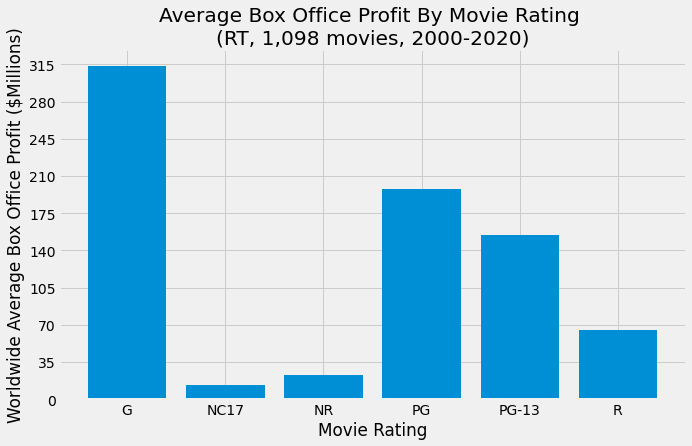

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
x = merge_imdb_rt_kaggle.groupby('content_rating')['Worldwide Net Profit'].mean().index
y = merge_imdb_rt_kaggle.groupby('content_rating')['Worldwide Net Profit'].mean().values
ax.bar(x,y)
ax.set_xlabel('Movie Rating')
ax.set_ylabel('Worldwide Average Box Office Profit ($Millions)')
ax.set_title('Average Box Office Profit By Movie Rating \n(RT, 1,098 movies, 2000-2020)')
ax.set_yticks(range(0,350000000,35000000))
ax.set_yticklabels(range(0,350,35));

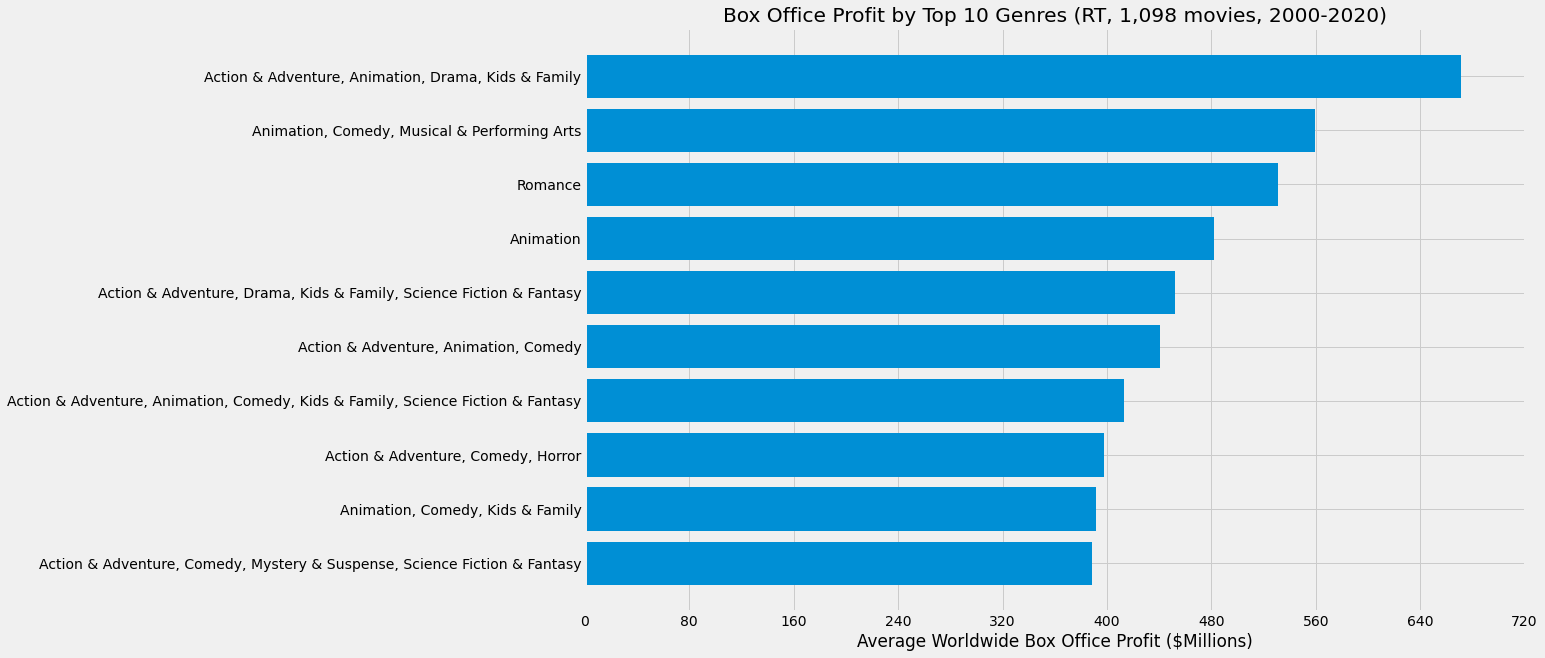

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
x = merge_imdb_rt_kaggle.groupby('genres')['Worldwide Net Profit'].mean()\
            .sort_values(ascending=False)[:10].sort_values().index
y = merge_imdb_rt_kaggle.groupby('genres')['Worldwide Net Profit'].mean()\
            .sort_values(ascending=False)[:10].sort_values().values
ax.barh(x,y)
ax.set_xlabel('Average Worldwide Box Office Profit ($Millions)')
ax.set_title('Box Office Profit by Top 10 Genres (RT, 1,098 movies, 2000-2020)')
ax.set_xticks(range(0,800000000,80000000))
ax.set_xticklabels(range(0,800,80));

In [66]:
#Drop all records with less than 50 reviews leaving 639 entries. 
#Find the correlation between the Tomatometer and Worldwide profit.
merge_imdb_rt_kaggle = merge_imdb_rt_kaggle[merge_imdb_rt_kaggle.tomatometer_rating >= 50]
merge_imdb_rt_kaggle.corr()['tomatometer_rating']['Worldwide Net Profit']

0.1197788260278433

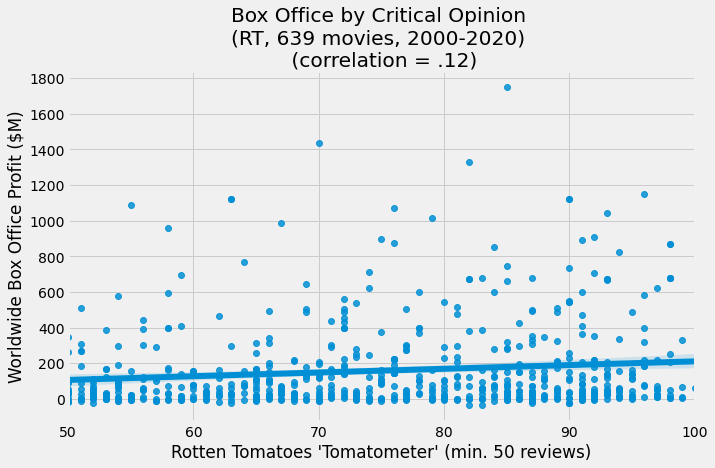

In [63]:
fig, ax = plt.subplots(figsize=(10,6))
x = merge_imdb_rt_kaggle.tomatometer_rating
y = merge_imdb_rt_kaggle['Worldwide Net Profit']
ax.scatter(x, y , alpha=.2)
sns.regplot(x=x,y=y)
ax.set_xlabel('Rotten Tomatoes \'Tomatometer\' (min. 50 reviews)')
ax.set_ylabel('Worldwide Box Office Profit ($M)')
ax.set_title('Box Office by Critical Opinion \n(RT, 639 movies, 2000-2020) \n (correlation = .12)')
ax.set_yticks(range(0,2000000000,200000000))
ax.set_yticklabels(range(0,2000,200));

,Worldwide Net Profit,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,year
Worldwide Net Profit,1.000000,0.228786,0.119779,0.404752,0.312868,0.370313,0.250056,0.377067,0.112416,0.086457
runtime,0.228786,1.000000,0.065822,0.493264,0.297436,0.228509,0.414172,0.409181,0.279560,0.143041
tomatometer_rating,0.119779,0.065822,1.000000,0.398909,0.646866,0.021552,0.369840,0.651993,-0.718495,0.120324
tomatometer_count,0.404752,0.493264,0.398909,1.000000,0.421226,0.235301,0.810914,0.944465,0.238647,0.369530
audience_rating,0.312868,0.297436,0.646866,0.421226,1.000000,0.202538,0.369254,0.554555,-0.362842,0.042641
audience_count,0.370313,0.228509,0.021552,0.235301,0.202538,1.000000,0.308886,0.184935,0.165792,-0.279791
tomatometer_top_critics_count,0.250056,0.414172,0.369840,0.810914,0.369254,0.308886,1.000000,0.760862,0.208380,0.059770
tomatometer_fresh_critics_count,0.377067,0.409181,0.651993,0.944465,0.554555,0.184935,0.760862,1.000000,-0.093706,0.342712
tomatometer_rotten_critics_count,0.112416,0.279560,-0.718495,0.238647,-0.362842,0.165792,0.208380,-0.093706,1.000000,0.108083
year,0.086457,0.143041,0.120324,0.369530,0.042641,-0.279791,0.059770,0.342712,0.108083,1.000000
